In [0]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pandas as pd
import importlib
from torch.utils.data.sampler import SubsetRandomSampler

from IPython.core.ultratb import AutoFormattedTB

__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [49]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [50]:
!rm -rf CS601R_Final_Project/ models/ datasets/ notebooks/
!git clone https://github.com/webMan1/CS601R_Final_Project.git
!cp -r CS601R_Final_Project/* .

Cloning into 'CS601R_Final_Project'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 70 (delta 32), reused 55 (delta 17), pack-reused 0
Unpacking objects: 100% (70/70), done.


In [0]:
import datasets.EncodedStanfordCarsDataset
import models.CLRDecoder
import importlib

datasets.EncodedStanfordCarsDataset = importlib.reload(datasets.EncodedStanfordCarsDataset)
models.CLRDecoder = importlib.reload(models.CLRDecoder)

CLRDecoder = models.CLRDecoder.CLRDecoder

# Training Loop

In [0]:
def train(model, optimizer, train_loader, valid_loader, num_epochs:int, valid_freq:int=10):
  train_len = len(train_loader)
  valid_len = len(valid_loader)
  loop = tqdm(total=(num_epochs * train_len + (num_epochs // valid_freq) * valid_len), position=0)

  train_losses = []
  train_accs = []

  valid_losses = []
  valid_accs = []

  criteria = nn.CrossEntropyLoss()

  for e in range(num_epochs):
    loss_builder = []
    acc_builder = []

    for i, (x, y_truth) in enumerate(train_loader):
      x, y_truth = x.cuda(async=False), y_truth.long().squeeze(1).cuda(async=False)
      optimizer.zero_grad()
      
      y_hat = model(x)

      total_loss = criteria(y_hat, y_truth)
      total_loss.backward()

      acc = y_truth.eq(y_hat.argmax(1)).sum().item() / len(y_truth)

      optimizer.step()

      loss_builder.append(total_loss.item())
      acc_builder.append(acc)

      loop.update(1)
      loop.set_description(f"Epoch: {e}, it: {i}/{train_len}. Loss: {total_loss.item()}. Acc: {acc}")
    
    train_accs.append(acc_builder)
    train_losses.append(loss_builder)

    if e % valid_freq == 0:
      loss_builder = []
      acc_builder = []

      with torch.no_grad():
        model.eval()

        for i, (x, y_truth) in enumerate(train_loader):
          x, y_truth = x.cuda(async=False), y_truth.long().squeeze(1).cuda(async=False)

        y_hat = model(x)

        total_loss = criteria(y_hat, y_truth)
        acc = y_truth.eq(y_hat.argmax(1)).sum().item() / len(y_truth)

        loss_builder.append(total_loss.item())
        acc_builder.append(acc)

        loop.update(1)
        loop.set_description(f"[VALIDATING] Epoch: {e}, it: {i}/{valid_len}. Loss: {total_loss.item()}. Acc: {acc}")

      model.train()

      valid_accs.append(acc_builder)
      valid_losses.append(loss_builder)
    
    state = {
        "model": model.state_dict(),
        "train_losses": train_losses,
        "train_accs": train_accs,
        "valid_losses": valid_losses,
        "valid_accs": valid_accs,
        "epoch": e
    }
    num = ((e + 4) // 5) * 5
    path = f"/content/gdrive/My Drive/SimCLR/models/stanford/clr_cross_e_{num}_linear.mod"
    torch.save(state, path)

  return train_losses, train_accs, valid_losses, valid_accs

In [0]:
def run_training():
  batch_size = 64
  model = CLRDecoder(196).cuda()
  optimizer = optim.Adam(model.parameters())

  train_loader = datasets.EncodedStanfordCarsDataset.get_loader(True, batch_size, True)
  valid_loader = datasets.EncodedStanfordCarsDataset.get_loader(False, batch_size, True)

  num_epochs = 71
  
  train_losses, train_accs, valid_losses, valid_accs = train(model, optimizer, train_loader, valid_loader, num_epochs=141, valid_freq=5)

  return train_losses, train_accs, valid_losses, valid_accs

In [54]:
res1 = run_training()

[VALIDATING] Epoch: 140, it: 127/126. Loss: 4.159952640533447. Acc: 0.1875:  84%|████████▍ | 18077/21576 [02:19<00:25, 136.80it/s]

In [0]:
train_losses, train_accs, train_faccs, valid_losses, valid_accs, valid_faccs = res1

# Test Results

In [0]:
def show_res(epoch:int, suffix:str):
  save_loc = f"/content/gdrive/My Drive/SimCLR/models/stanford/clr_cross_e_{epoch}_linear.mod"
  state = torch.load(save_loc)
  
  epoch = state["epoch"]
  
  train_losses, train_accs = state["train_losses"], state["train_accs"]
  valid_losses, valid_accs = state["valid_losses"], state["valid_accs"]

  train_loss_averages = [ np.mean(l) for l in train_losses]
  valid_loss_averages = [ np.mean([i for i in l]) for l in valid_losses]

  train_acc_averages = [ np.mean([i for i in l]) for l in train_accs]
  valid_acc_averages = [ np.mean([i for i in l]) for l in valid_accs]

  print(f"Got to epoch {epoch}")
  plt.title("Loss")
  plt.plot(train_loss_averages)
  plt.plot(range(0, len(train_loss_averages), 5), valid_loss_averages)
  plt.show()

  plt.title("Accuracy")
  plt.plot(train_acc_averages)
  plt.plot(range(0, len(train_acc_averages), 5), valid_acc_averages)
  plt.show()

  return state

Got to epoch 140


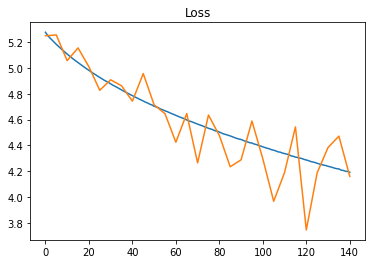

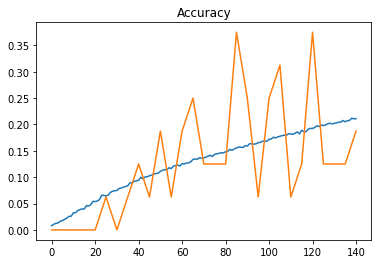

In [56]:
state = show_res(140, "")
# print(state["valid_losses"])
# state2 = show_res(False, 15)

In [0]:
loader = get_loader(False, 32)

Using the Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object') attribute as the label
torch.Size([19867, 40])
Mask shape: (202599,)


In [0]:
model = CLRDecoder(True)
model.load_state_dict(state['model'])

test_its = 100000000
sigmoid = nn.Sigmoid()

accs = []
naive_accs = []
for i, (x, y) in zip(range(test_its), loader):
  # pred = torch.stack(model(x)).permute(1, 0, 2).argmax(dim=2)
  pred = sigmoid(model(x))
  # print("Predicted:")
  # print((pred > 0.5).int().tolist())
  # print("Actual")
  # print(y.tolist())

  diff = (pred > 0.5).int().eq(y)
  acc = diff.sum().item() / diff.numel()
  accs.append(acc)

  num_tg_ones = y.sum().item()
  naive_acc = 1 - (num_tg_ones / diff.numel())
  naive_accs.append(naive_acc)
print(f"Accuracy: {np.average(accs)}")
print(f"Naive acc would be {np.average(naive_acc)}")


Accuracy: 0.8930730750879703
Naive acc would be 0.7833333333333333
